# Events Germany

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import NMF

In [78]:
# Notes:
bayern_wyid = 2444

## Load Events

In [79]:
df_events = pd.read_csv('event_streams/events_germany.csv')
df_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tagsList,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x
0,8,Simple pass,[{'id': 1801}],15231,"[{'y': 50, 'x': 50}, {'y': 48, 'x': 50}]",2516739,Pass,2446,1H,2.409746,85.0,179896442,[1801],50,50,48,50
1,8,Simple pass,[{'id': 1801}],14786,"[{'y': 48, 'x': 50}, {'y': 22, 'x': 22}]",2516739,Pass,2446,1H,2.506082,85.0,179896443,[1801],48,50,22,22
2,8,Simple pass,[{'id': 1801}],14803,"[{'y': 22, 'x': 22}, {'y': 46, 'x': 6}]",2516739,Pass,2446,1H,6.946706,85.0,179896444,[1801],22,22,46,6
3,8,Simple pass,[{'id': 1801}],14768,"[{'y': 46, 'x': 6}, {'y': 10, 'x': 20}]",2516739,Pass,2446,1H,10.786491,85.0,179896445,[1801],46,6,10,20
4,8,Simple pass,[{'id': 1801}],14803,"[{'y': 10, 'x': 20}, {'y': 4, 'x': 27}]",2516739,Pass,2446,1H,12.684514,85.0,179896446,[1801],10,20,4,27


In [80]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519357 entries, 0 to 519356
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       519357 non-null  int64  
 1   subEventName  518138 non-null  object 
 2   tags          519357 non-null  object 
 3   playerId      519357 non-null  int64  
 4   positions     519357 non-null  object 
 5   matchId       519357 non-null  int64  
 6   eventName     519357 non-null  object 
 7   teamId        519357 non-null  int64  
 8   matchPeriod   519357 non-null  object 
 9   eventSec      519357 non-null  float64
 10  subEventId    518138 non-null  float64
 11  id            519357 non-null  int64  
 12  tagsList      468651 non-null  object 
 13  pos_orig_y    519357 non-null  int64  
 14  pos_orig_x    519357 non-null  int64  
 15  pos_dest_y    519357 non-null  int64  
 16  pos_dest_x    519357 non-null  int64  
dtypes: float64(2), int64(9), object(6)
memory usage:

#### Drop missing values

In [81]:
# Drop missing values
df_events = df_events.dropna()
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468629 entries, 0 to 519356
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       468629 non-null  int64  
 1   subEventName  468629 non-null  object 
 2   tags          468629 non-null  object 
 3   playerId      468629 non-null  int64  
 4   positions     468629 non-null  object 
 5   matchId       468629 non-null  int64  
 6   eventName     468629 non-null  object 
 7   teamId        468629 non-null  int64  
 8   matchPeriod   468629 non-null  object 
 9   eventSec      468629 non-null  float64
 10  subEventId    468629 non-null  float64
 11  id            468629 non-null  int64  
 12  tagsList      468629 non-null  object 
 13  pos_orig_y    468629 non-null  int64  
 14  pos_orig_x    468629 non-null  int64  
 15  pos_dest_y    468629 non-null  int64  
 16  pos_dest_x    468629 non-null  int64  
dtypes: float64(2), int64(9), object(6)
memory usage: 64.4

In [82]:
# Normalize data (naive assumption, need to work on this!)
def normalize_playing_direction(data):
    data_normalized = data.copy()
    for index, row in data.iterrows():
        # if row['matchPeriod'] == '2H':
        if row['pos_orig_x'] > 50:
            # Flip coordinates for consistent direction
            data_normalized.at[index, 'pos_orig_x'] = 100 - row['pos_orig_x']
            data_normalized.at[index, 'pos_dest_x'] = 100 - row['pos_dest_x']
            data_normalized.at[index, 'pos_orig_y'] = 100 - row['pos_orig_y']
            data_normalized.at[index, 'pos_dest_y'] = 100 - row['pos_dest_y']
    return data_normalized
df_events = normalize_playing_direction(df_events)

## Load Players

In [83]:
df_players = pd.read_csv('event_streams/players.csv', encoding='utf-8')
df_players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,NaN,Tekin,4502.0,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687.0
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,NaN,Sarr,3775.0,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423.0
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,NaN,Mandanda,3772.0,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,NaN,O. Mandanda,NaN
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314.0
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,NaN,Konat\u00e9,2975.0,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,NaN


In [84]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passportArea           3603 non-null   object 
 1   weight                 3603 non-null   int64  
 2   firstName              3603 non-null   object 
 3   middleName             0 non-null      float64
 4   lastName               3603 non-null   object 
 5   currentTeamId          3468 non-null   float64
 6   birthDate              3603 non-null   object 
 7   height                 3603 non-null   int64  
 8   role                   3603 non-null   object 
 9   birthArea              3603 non-null   object 
 10  wyId                   3603 non-null   int64  
 11  foot                   3551 non-null   object 
 12  shortName              3603 non-null   object 
 13  currentNationalTeamId  1357 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 394.2+ 

#### Map playerID to 8-Tuple:
* TeamID
* First Name
* Last Name
* Role
* Foot
* Height
* Weight

In [85]:
players = {row['wyId']: (
    row['currentTeamId'],
    row['firstName'],
    row['lastName'],
    row['role'],
    row['foot'],
    row['height'],
    row['weight'])
    for _, row in df_players.iterrows()}

## Load Clubs

In [86]:
df_teams = pd.read_csv('event_streams/teams.csv', encoding='utf-8')
df_teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [87]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          142 non-null    object
 1   name          142 non-null    object
 2   wyId          142 non-null    int64 
 3   officialName  142 non-null    object
 4   area          142 non-null    object
 5   type          142 non-null    object
dtypes: int64(1), object(5)
memory usage: 6.8+ KB


#### Map TeamID to Team Name

In [88]:
# Map wyscout-id to team name
team_names = dict(zip(df_teams.wyId, df_teams.officialName))

#### Map TeamID to a list of its player ids

In [89]:
# Map teamID's to a list of its player ids
teams = {teamID: [playerID for playerID in players if teamID == players[playerID][0]] for teamID in team_names}

## Building Player Vectors

#### Select relevant action types:
* Pass
* Shot
* Ground Attacking Duell (since there is no dribble action)
* Cross

In [90]:
# Extracting relevant action types from dataframe
df_pass = df_events.loc[df_events['subEventName'] == 'Simple pass']
df_shot = df_events.loc[df_events['subEventName'] == 'Shot']
df_cross = df_events.loc[df_events['subEventName'] == 'Cross']
df_duell = df_events.loc[df_events['subEventName'] == 'Ground attacking duell']

In [91]:
# Group player by 'player_id', store actions coordinates in lists
passes = df_pass.groupby(['playerId']).agg({'pos_orig_x': list, 'pos_orig_y': list})
shots = df_shot.groupby(['playerId']).agg({'pos_orig_x': list, 'pos_orig_y': list})
crosses = df_pass.groupby(['playerId']).agg({'pos_orig_x': list, 'pos_orig_y': list})
duells = df_cross.groupby(['playerId']).agg({'pos_orig_x': list, 'pos_orig_y': list})

In [92]:
passes.head()

,pos_orig_x,pos_orig_y
playerId,,
0,"[48, 40, 30]","[21, 87, 39]"
77,"[0, 24, 0, 28, 12, 38, 27, 46, 29, 19, 33, 49,...","[0, 27, 0, 6, 5, 17, 6, 24, 40, 61, 88, 57, 65..."
91,"[25, 31, 33, 20, 34, 30, 36, 22, 10, 37, 28, 4...","[23, 64, 4, 11, 64, 10, 91, 71, 91, 74, 36, 70..."
110,"[13, 41, 37, 41, 4, 14, 37, 42, 45, 35, 34, 18...","[74, 96, 4, 5, 91, 96, 96, 96, 84, 83, 75, 87,..."
159,"[32, 30, 27, 12, 27, 21, 28, 32, 30, 29, 40, 4...","[61, 74, 59, 68, 69, 93, 56, 63, 61, 53, 70, 8..."


In [93]:
shots.head()

,pos_orig_x,pos_orig_y
playerId,,
77,"[38, 32, 20, 46, 25, 27, 11, 17, 36, 27, 25, 3...","[64, 49, 70, 50, 41, 42, 32, 75, 28, 78, 4, 10..."
91,"[24, 4, 46, 28, 30]","[93, 29, 55, 69, 32]"
110,"[10, 25, 11, 41, 45, 41, 0, 0, 37, 49, 44, 50,...","[71, 27, 47, 26, 94, 78, 0, 0, 41, 4, 0, 63, 8..."
159,"[0, 0, 11, 29, 5, 43, 32, 5, 4, 38, 26, 42, 29...","[0, 0, 33, 76, 56, 89, 49, 45, 58, 20, 64, 100..."
1722,"[0, 41, 49, 43, 41, 2]","[0, 77, 42, 68, 100, 12]"


In [94]:
crosses.head()

,pos_orig_x,pos_orig_y
playerId,,
0,"[48, 40, 30]","[21, 87, 39]"
77,"[0, 24, 0, 28, 12, 38, 27, 46, 29, 19, 33, 49,...","[0, 27, 0, 6, 5, 17, 6, 24, 40, 61, 88, 57, 65..."
91,"[25, 31, 33, 20, 34, 30, 36, 22, 10, 37, 28, 4...","[23, 64, 4, 11, 64, 10, 91, 71, 91, 74, 36, 70..."
110,"[13, 41, 37, 41, 4, 14, 37, 42, 45, 35, 34, 18...","[74, 96, 4, 5, 91, 96, 96, 96, 84, 83, 75, 87,..."
159,"[32, 30, 27, 12, 27, 21, 28, 32, 30, 29, 40, 4...","[61, 74, 59, 68, 69, 93, 56, 63, 61, 53, 70, 8..."


In [95]:
duells.head()

,pos_orig_x,pos_orig_y
playerId,,
77,"[19, 10, 27, 28, 35, 43, 36, 18]","[23, 22, 28, 70, 23, 42, 85, 88]"
91,"[5, 28, 6]","[0, 91, 67]"
110,"[10, 25, 7, 16, 4, 12, 5, 6, 5, 38, 37, 0, 31,...","[88, 4, 94, 7, 7, 72, 88, 27, 5, 95, 94, 34, 3..."
159,"[9, 9, 33, 48, 24, 18, 36, 46, 30, 0, 43, 0, 0]","[26, 4, 27, 40, 24, 48, 48, 88, 23, 0, 66, 0, 0]"
1722,"[28, 16, 47]","[72, 8, 0]"


### Heatmap parameters
* M, N: rows, columns of heatmap
* Sigma for gaussian blur
* Num of componnents in NMF


In [102]:
# Heatmap parameters
N, M = 50, 50
sigma = 6.0
k = 4

### 1. Calculating Heatmaps

#### 1.1: Counting + Normalizing + Smoothing

In [103]:
heatmaps_shot = {}

# Counting and smoothing
for _, row in shots.iterrows():
    playerID = row.name
    x = row.pos_orig_x
    y = row.pos_orig_y
    
    # Counting via numpy 2d histogramm 
    X, _, _ = np.histogram2d(x, y, bins=[N, M])
    
    # Gaussian blur
    X = gaussian_filter(X, sigma=sigma) 
    heatmaps_shot[playerID] = X

#### Visualize Heatmaps for Bayern Muenchen

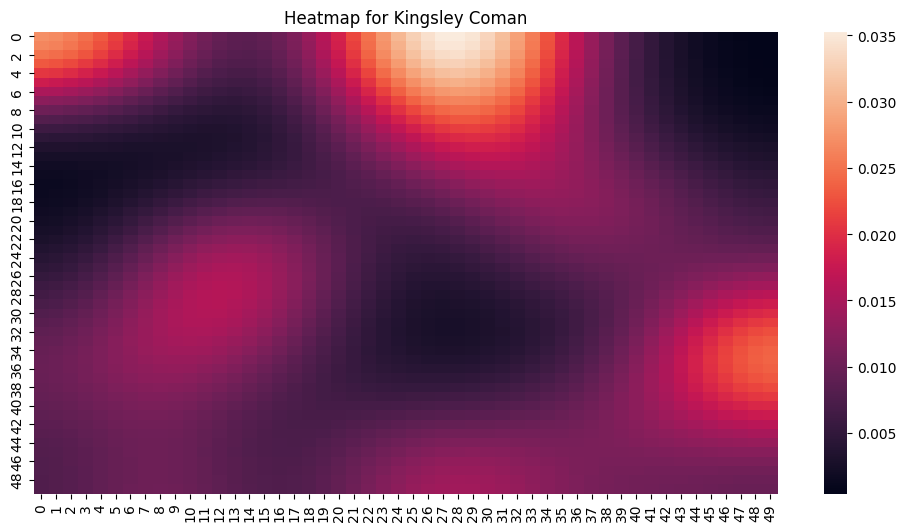

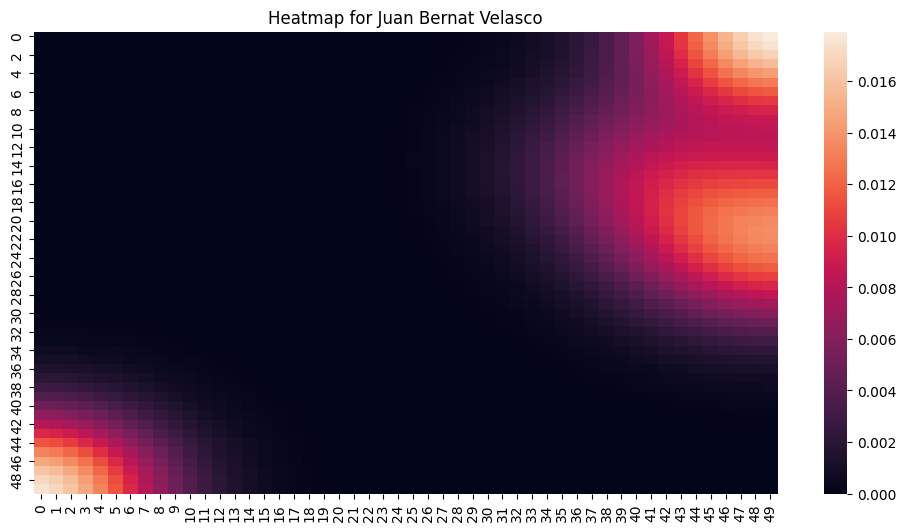

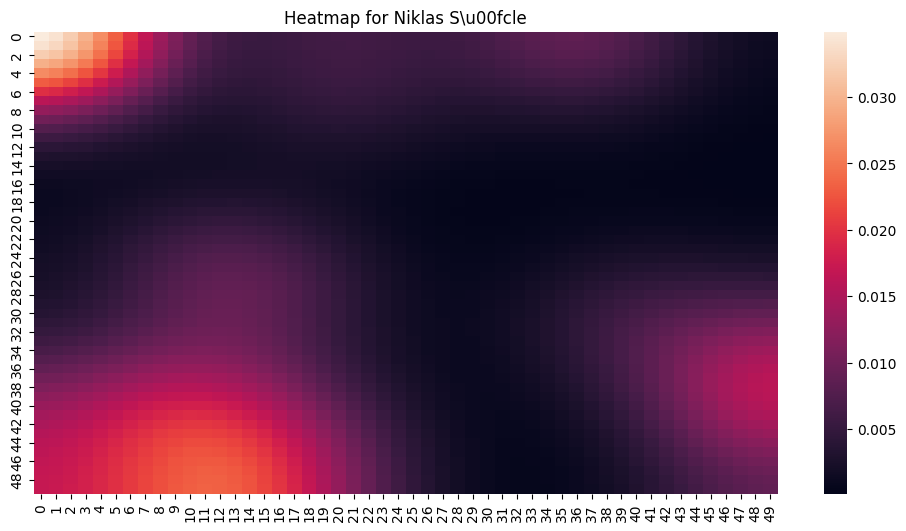

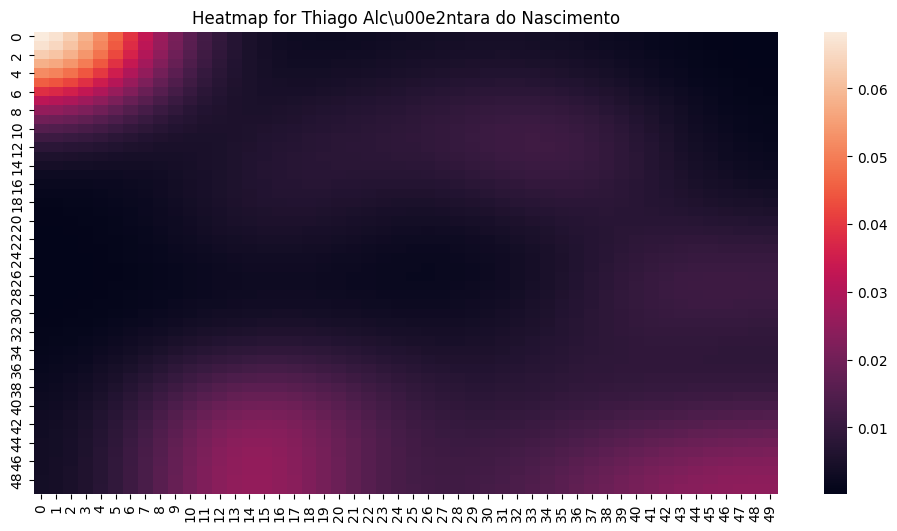

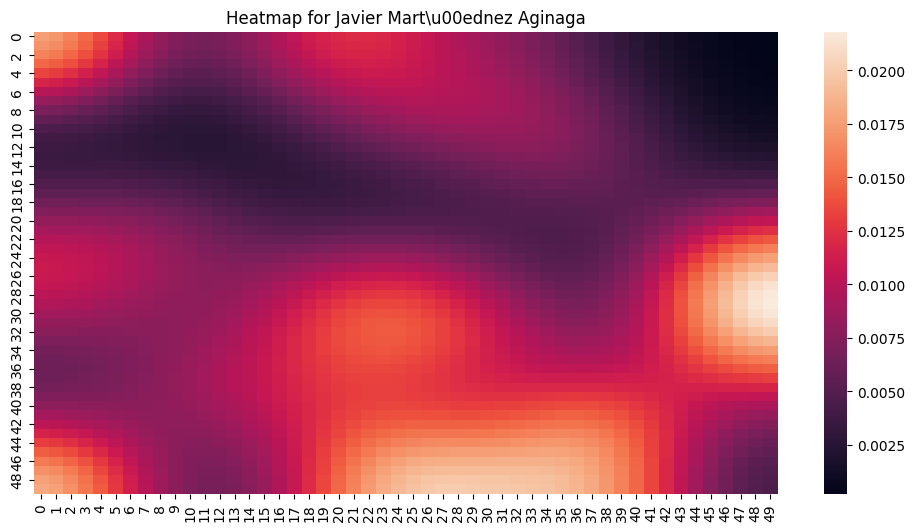

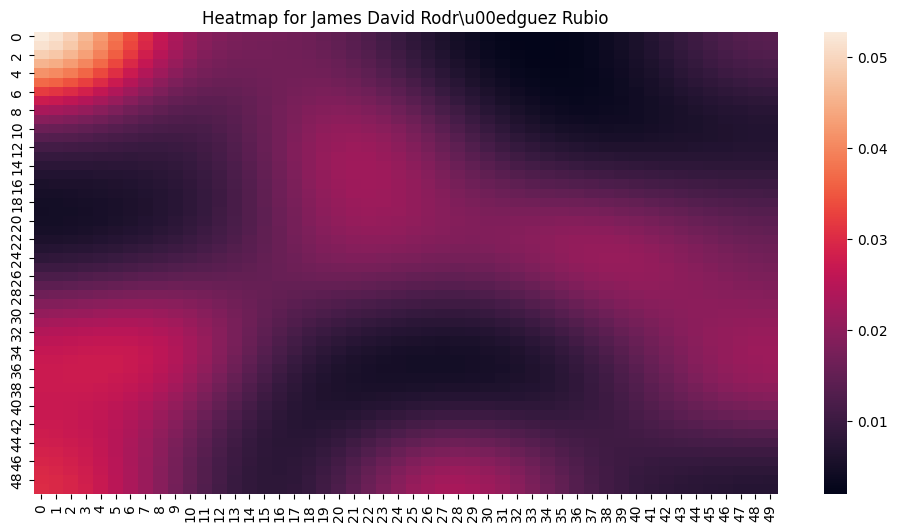

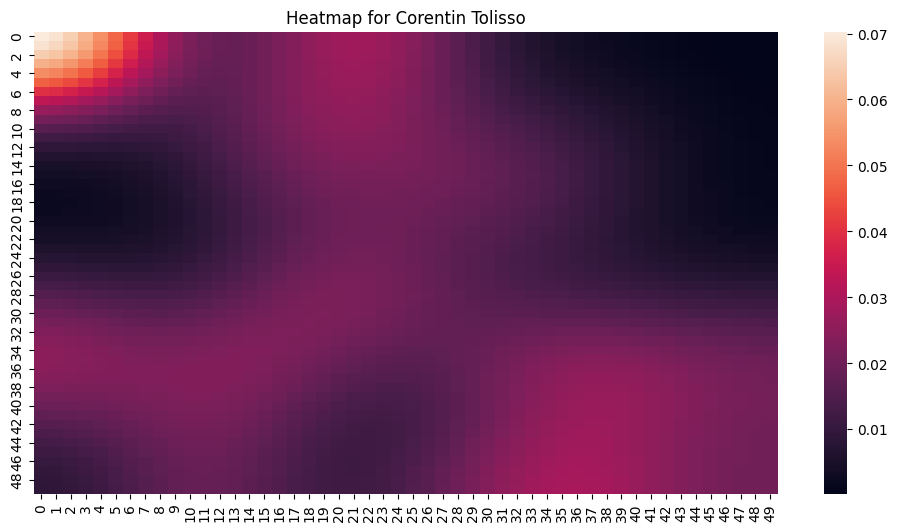

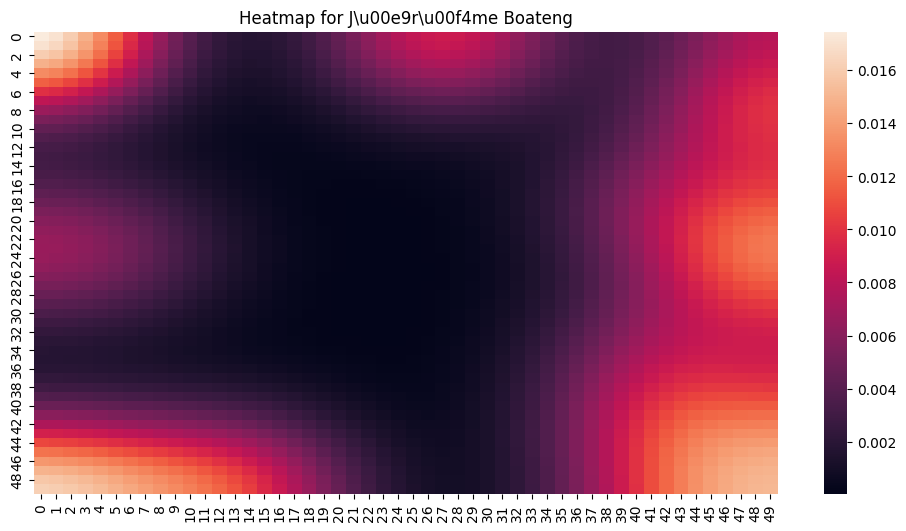

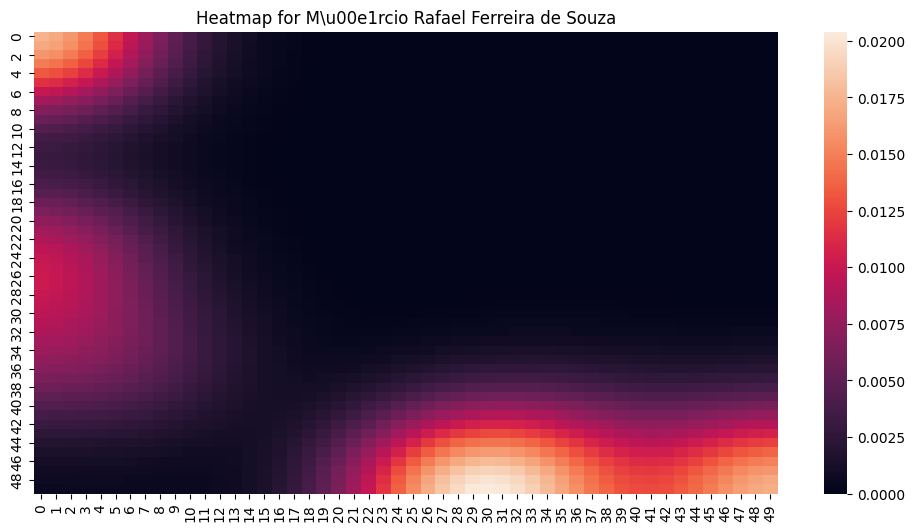

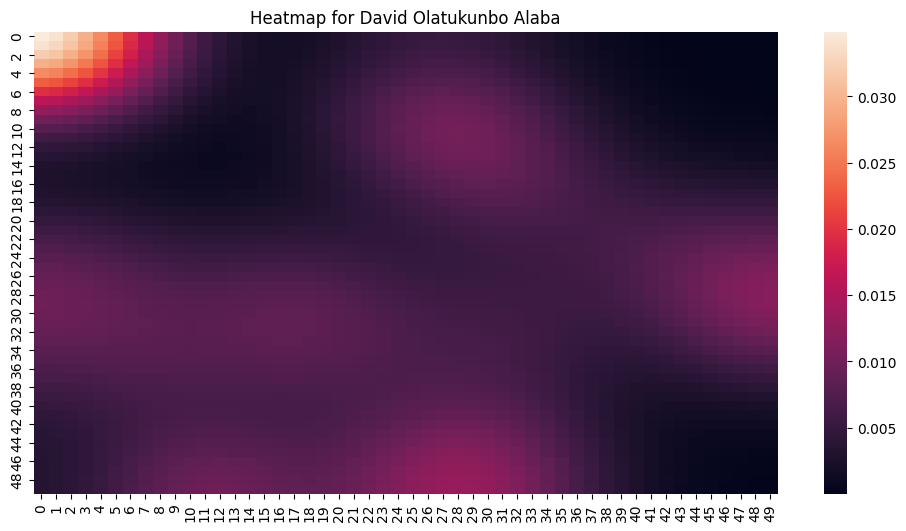

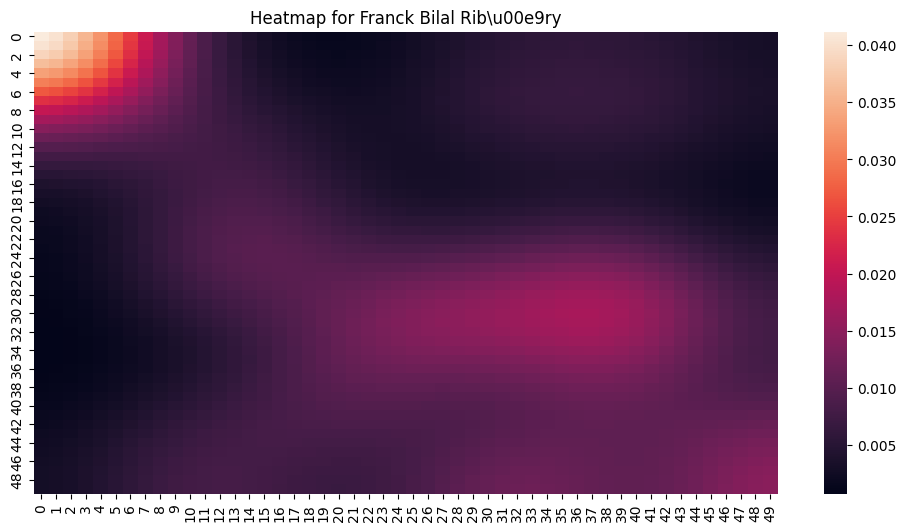

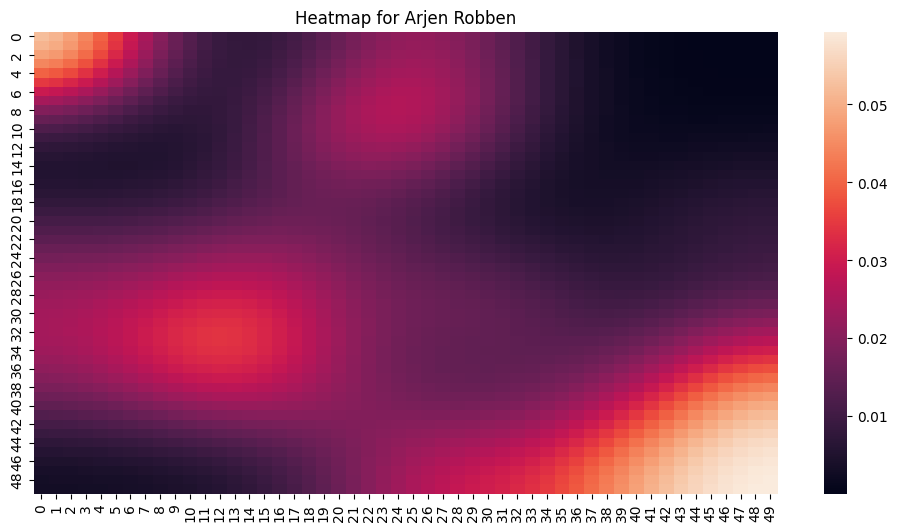

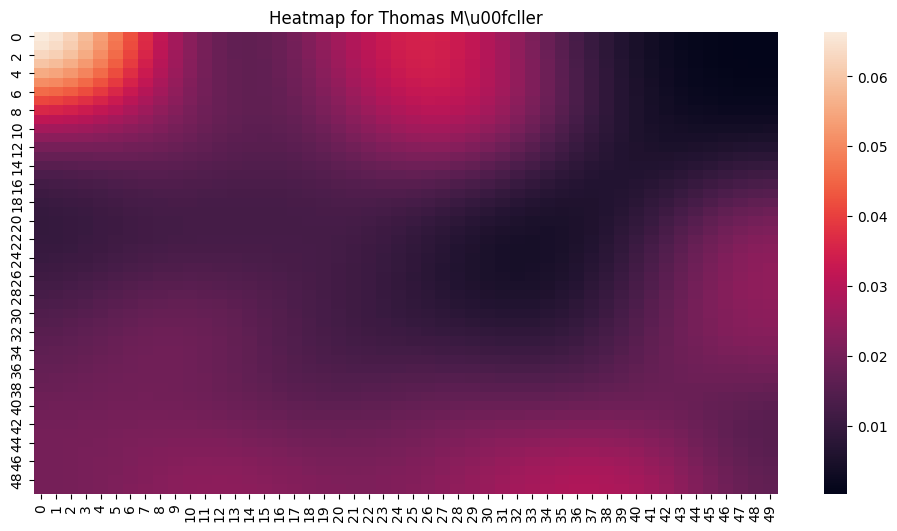

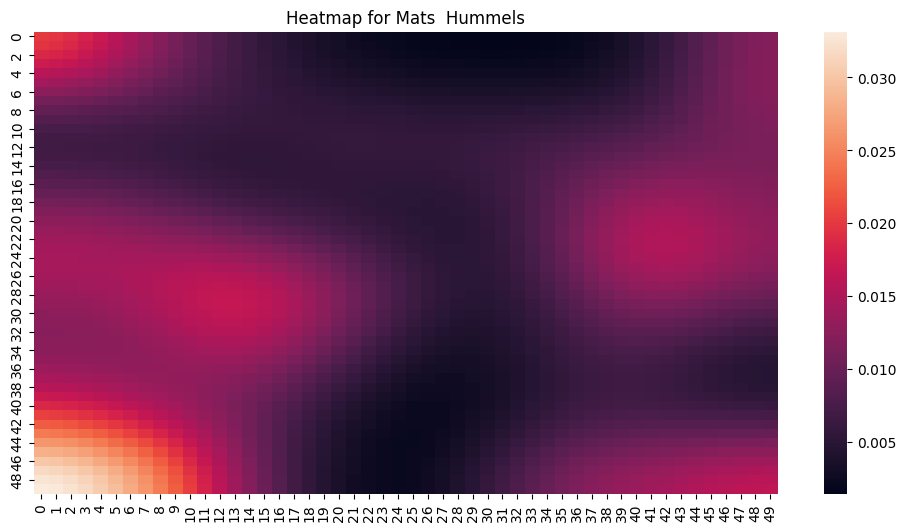

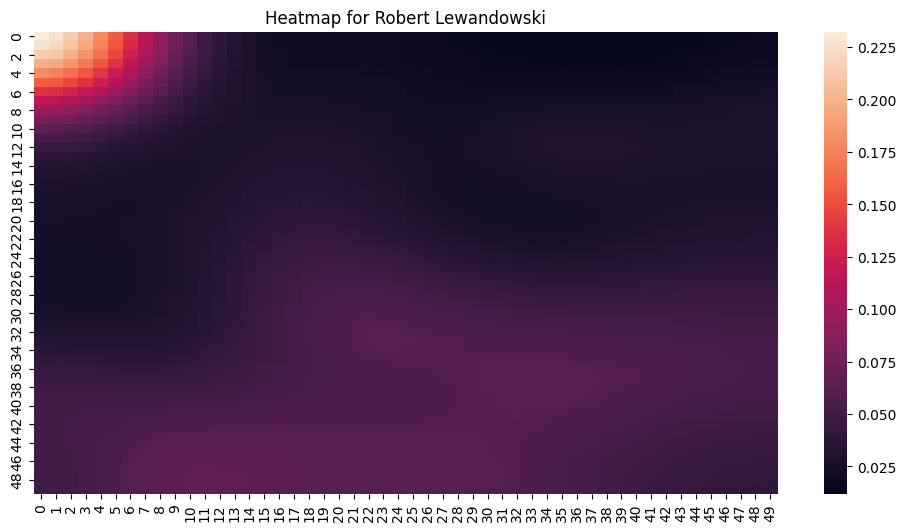

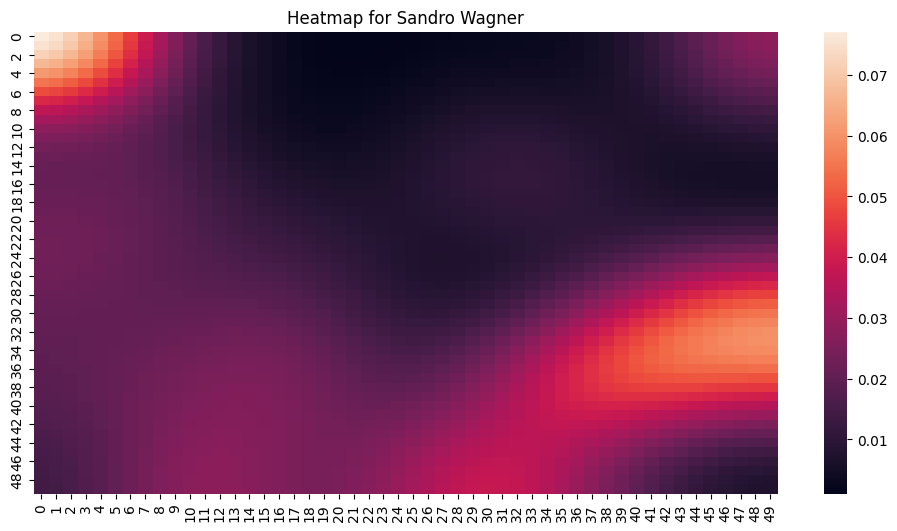

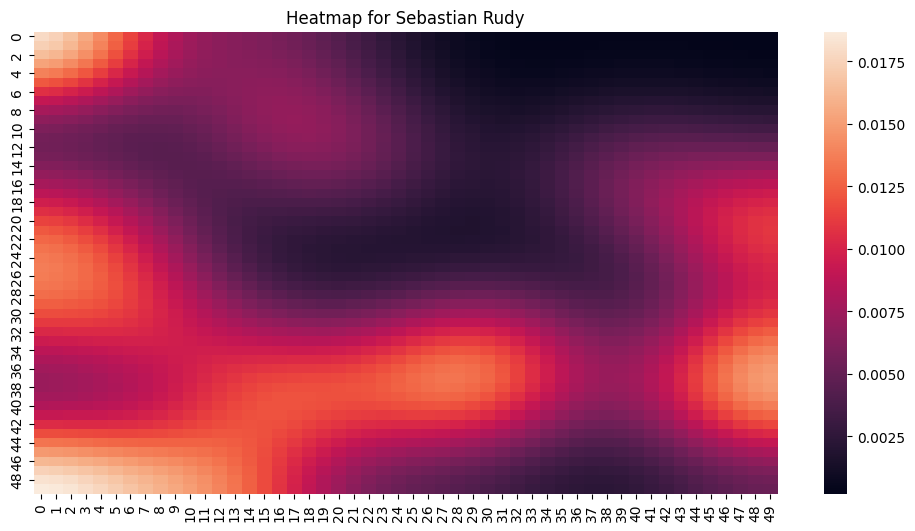

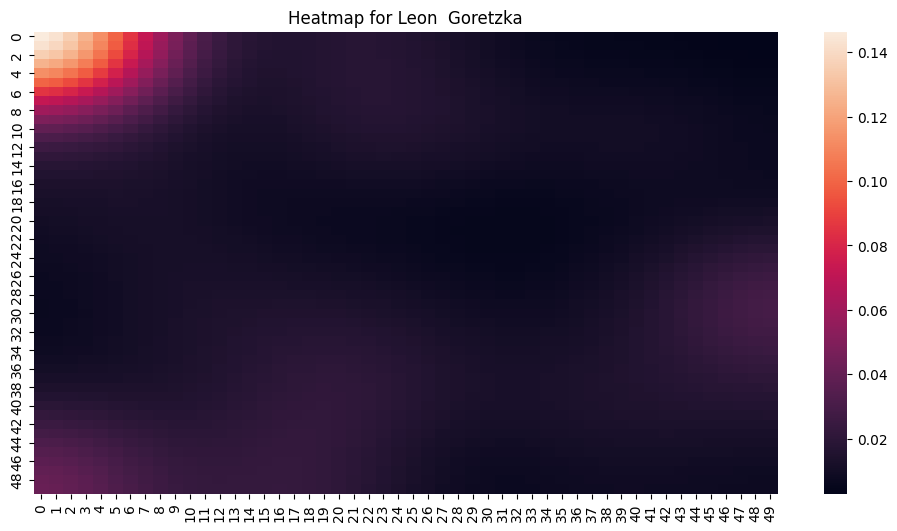

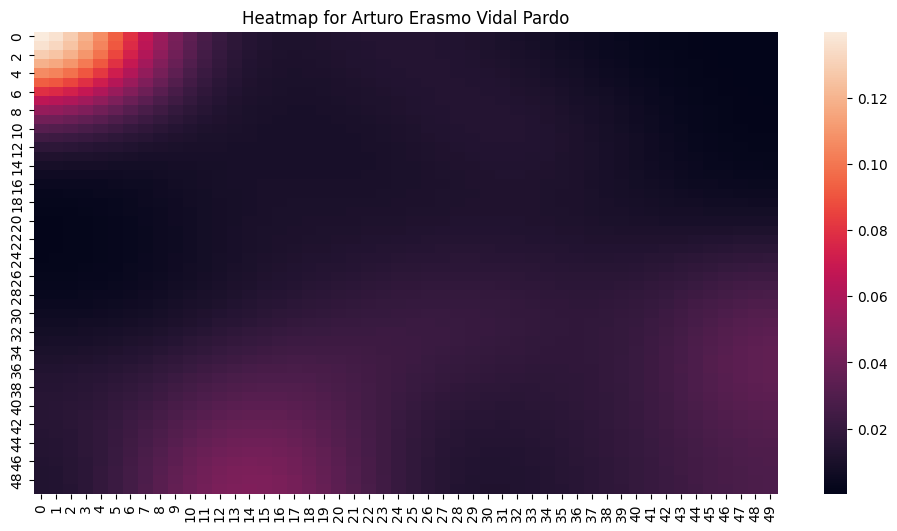

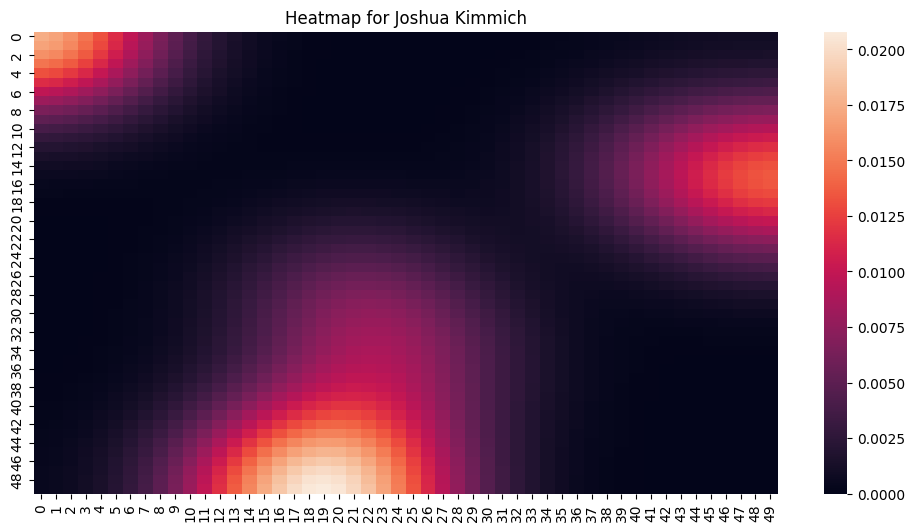

In [104]:
for playerID in teams[bayern_wyid]:
    if playerID in heatmaps_shot:
        X = heatmaps_shot[playerID]
        plt.figure(figsize=(12, 6)) 
        plt.title(f'Heatmap for {players[playerID][1]} {players[playerID][2]}') 
        sns.heatmap(X)
        plt.show()